In [24]:
import requests
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter
import numpy as np

# Total number of levels including level0
number_of_levels = 7

# Analytics mode
# mode = 'test'
mode = 'production'

test_url = 'https://side-n-top-default-rtdb.firebaseio.com/test/.json'
production_url = 'https://side-n-top-default-rtdb.firebaseio.com/events/.json'

test_file = 'test.csv'
production_file = 'production.csv'

url = test_url if mode == 'test' else production_url
out_put_file = test_file if mode == 'test' else production_file

In [2]:
response = requests.get(url)
if response.status_code == 200:
    data = response.json()
    # print(data)
else:
    print("Failure Request：", response.status_code)

In [3]:
# Extract all events into a csv
all_events = []
for key, value in data.items():
    if isinstance(value, dict) and 'events' in value:
        all_events.extend(value['events'])
        
fieldnames = all_events[0].keys()
with open(out_put_file, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(all_events)

print(f"CSV file saved as {out_put_file} with {len(all_events)} rows.")

CSV file saved as production.csv with 5770 rows.


In [4]:
# Group events by their SessionID
grouped_events = {}

for event in all_events:
    session_id = event.get('sessionId')
    if session_id not in grouped_events:
        grouped_events[session_id] = []
    grouped_events[session_id].append(event)

for session_id, events in grouped_events.items():
    print(f"There are {len(events)} events in SessionID: {session_id}")

There are 1 events in SessionID: 83fd3861-aacf-4be7-8ebd-0ac255fbbb6c
There are 2 events in SessionID: 1c5f9dfe-4b43-484a-9ec3-fbd0b862eb6c
There are 3 events in SessionID: 7991c1bc-ccac-414d-b056-91b9e37420c2
There are 2 events in SessionID: ff04845b-f299-4c5c-ac8c-c7352640b570
There are 1 events in SessionID: c08c8fb0-425c-4749-93c2-6c0818bb119b
There are 2 events in SessionID: 557c77ca-1826-4cfc-a92f-b1881bca7df5
There are 2 events in SessionID: 4ce46883-7a4e-4c2d-bb5f-8d12b2235582
There are 2 events in SessionID: cf5d7617-b3c2-40f9-bedd-514fd34cf8ad
There are 1 events in SessionID: 8a7737d8-098e-4ed2-996d-8a26536f492b
There are 2 events in SessionID: f9decb6f-7e10-4fe5-8d50-af9f18a7ed31
There are 2 events in SessionID: 224b5ac9-cf9e-427c-9b45-46ae315e5c13
There are 6 events in SessionID: 1343289b-6cb0-4565-92cd-b357b5afd8e3
There are 1 events in SessionID: 902357a5-0aac-405a-a2a8-670f2a03f07b
There are 2 events in SessionID: 4507bd52-4396-4ced-88c6-77c882937839
There are 1 events i

In [11]:
# TODO
level_dict = {f'Level{i}': i for i in range(number_of_levels)}

# Metric 1
end_causes_by_level = [{} for _ in range(number_of_levels)]

# Metric 2
total_number_of_shift_by_level = [0] * number_of_levels
total_number_of_session_by_level = [0] * number_of_levels
average_number_of_shift_by_level = [0] * number_of_levels

# Metric 3
shift_positions_topdown_by_level = [[] for _ in range(number_of_levels)]
shift_positions_platformer_by_level = [[] for _ in range(number_of_levels)]

# Metric 4
average_topdown_time_by_session_by_level = [[] for _ in range(number_of_levels)]
average_topdown_ratio_by_level = [0] * number_of_levels

for session_id, events in grouped_events.items():
    if len(events) < 2:
        continue

    # Sort events by timestamp
    events = sorted(events, key=lambda x: x.get('timestamp', 0))
    level_id = events[0].get('levelId')
    level_idx = level_dict[level_id]
    
    is_topdown = events[0].get('viewBeforeEvent') == 'TopDown'  # Initial state
    topdown_time = 0
    platformer_time = 0
    end = 'Win'
    shift_count = 0

    for i in range(1, len(events)):
        event = events[i]
        prev_event = events[i - 1]

        # Sum topdown_time or platformer_time
        time_interval = event.get('timestamp', 0) - prev_event.get('timestamp', 0)
        if event.get('eventType') in ['Lose', 'Win', 'Shift']:
            if is_topdown:
                topdown_time += time_interval
            else:
                platformer_time += time_interval

            # Shift Event
            if event.get('eventType') == 'Shift':
                shift_count += 1
                position = event.get('position', None)
                if position:
                    if is_topdown:
                        shift_positions_topdown_by_level[level_idx].append(position)
                    else:
                        shift_positions_platformer_by_level[level_idx].append(position)
                is_topdown = not is_topdown  # Flip view after shift

            # End an analytics session
            if event.get('eventType') == 'Win':
                end = 'Win'
            if event.get('eventType') == 'Lose':
                end = event.get('reason')

    # For each session, calculate each metric
    total_time = topdown_time + platformer_time

    # Metric 1
    if end not in end_causes_by_level[level_idx]:
        end_causes_by_level[level_idx][end] = 1
    else:
        end_causes_by_level[level_idx][end] += 1

    # Metric 2
    total_number_of_shift_by_level[level_idx] += shift_count
    total_number_of_session_by_level[level_idx] += 1

    # Metric 3
    # shift_positions_topdown_by_level
    # shift_positions_platformer_by_level

    # Metric 4
    average_topdown_time_by_session = topdown_time / total_time if total_time != 0 else 0
    average_topdown_time_by_session_by_level[level_idx].append(average_topdown_time_by_session)

for i in range(number_of_levels):
    # Metric 1
    # end_causes_by_level
    
    # Metric 2
    average_number_of_shift_by_level[i] = (total_number_of_shift_by_level[i] / total_number_of_session_by_level[i] 
                                           if total_number_of_session_by_level[i] != 0 else 0)
    # Metric 3
    # shift_positions_topdown_by_level
    # shift_positions_platformer_by_level
    
    # Metric 4
    average_topdown_ratio_by_level[i] = (sum(average_topdown_time_by_session_by_level[i]) / 
                                         len(average_topdown_time_by_session_by_level[i]) 
                                         if len(average_topdown_time_by_session_by_level[i]) != 0 else 0)

print("--------------------Metric 1-------------------------")
print(end_causes_by_level)
print()
print("--------------------Metric 2-------------------------")
print(average_number_of_shift_by_level)
print()
print("--------------------Metric 3-------------------------")
print("Topdown Shift Positions by Level:")
print(shift_positions_topdown_by_level)
print()
print("Platformer Shift Positions by Level:")
print(shift_positions_platformer_by_level)
print()
print("--------------------Metric 4-------------------------")
print(average_topdown_ratio_by_level)


--------------------Metric 1-------------------------
[{'KillZone': 100, 'Win': 113}, {'Win': 103, 'Pit': 142, 'KillZone': 3}, {'Win': 97, 'KillZone': 144, 'Pit': 52}, {'Win': 72, 'KillZone': 59, 'MovingCylinder': 114, 'Pit': 69}, {'Win': 43, 'KillZone': 32, 'Pit': 4}, {'Win': 43, 'KillZone': 3, 'MovingCylinder': 4, 'Laser': 11, 'Pit': 1}, {'KillZone': 29, 'MovingCylinder': 36, 'Win': 15}]

--------------------Metric 2-------------------------
[0.0, 0.0, 2.7679180887372015, 3.799363057324841, 3.6455696202531644, 5.161290322580645, 6.125]

--------------------Metric 3 (New)-------------------------
Topdown Shift Positions by Level:
[[], [], [{'x': 2.0, 'y': -12.000022888183594, 'z': -0.5}, {'x': 3.9999988079071045, 'y': -8.000015258789062, 'z': -0.5}, {'x': 3.9999988079071045, 'y': -8.000015258789062, 'z': -0.5}, {'x': -4.000004291534424, 'y': -14.0, 'z': -0.5}, {'x': 4.999998569488525, 'y': -12.000017166137695, 'z': -0.5}, {'x': 4.999999046325684, 'y': -11.000015258789062, 'z': -0.5}, 

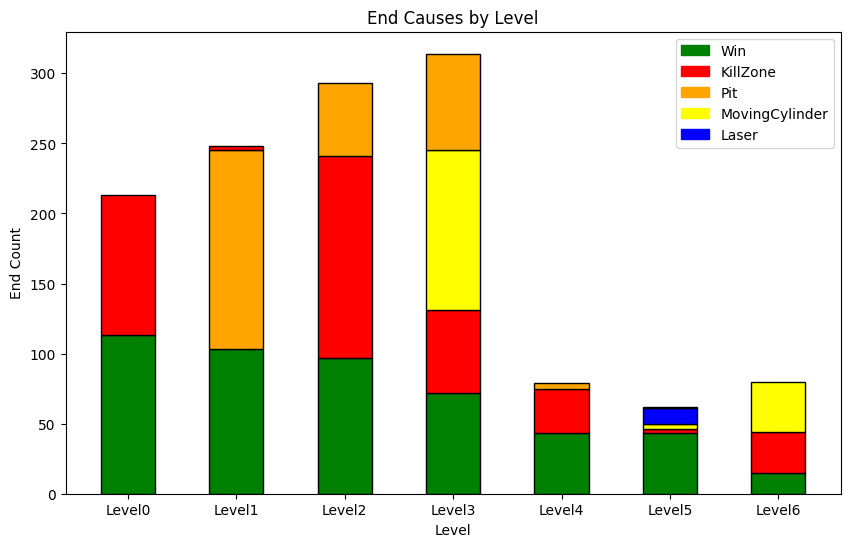

In [6]:
# -------------------- Metric 1: End Causes by Level --------------------
levels = [f'Level{i}' for i in range(len(end_causes_by_level))]
color_mapping = {
    "Win": "green",
    "KillZone": "red",
    "Pit": "orange",
    "MovingCylinder": "yellow",
    "Laser": "blue"
}
default_color = "gray"
bar_width = 0.5

plt.figure(figsize=(10, 6))
for i, causes in enumerate(end_causes_by_level):
    bottom = 0
    # Sort causes so that 'Win' is always drawn first (at the bottom)
    sorted_causes = sorted(causes.items(), key=lambda x: 0 if x[0] == "Win" else 1)
    for cause, count in sorted_causes:
        color = color_mapping.get(cause, default_color)
        plt.bar(levels[i], count, bottom=bottom, width=bar_width, color=color, edgecolor='black', 
                label=cause if i == 0 else "")
        bottom += count

plt.xlabel('Level')
plt.ylabel('End Count')
plt.title('End Causes by Level')
legend_handles = [mpatches.Patch(color=color, label=cause) for cause, color in color_mapping.items()]
plt.legend(handles=legend_handles)
plt.show()

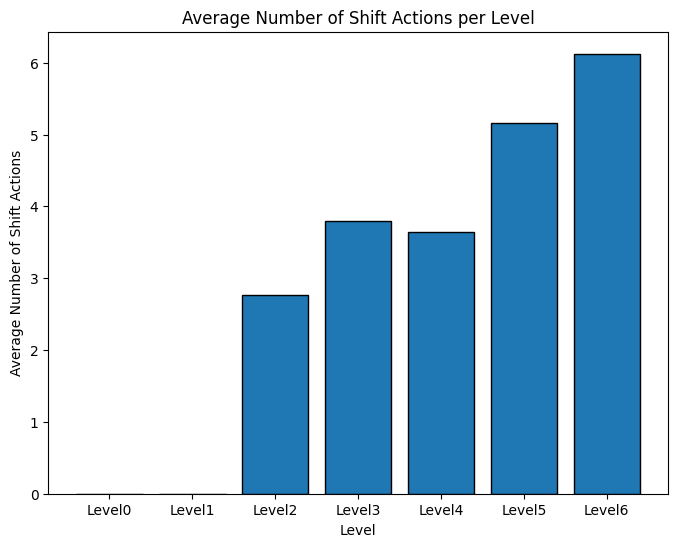

In [7]:
# -------------------- Metric 2: Average Number of Shift Actions per Level --------------------
plt.figure(figsize=(8, 6))
plt.bar(levels, average_number_of_shift_by_level, edgecolor='black')
plt.xlabel('Level')
plt.ylabel('Average Number of Shift Actions')
plt.title('Average Number of Shift Actions per Level')
plt.show()

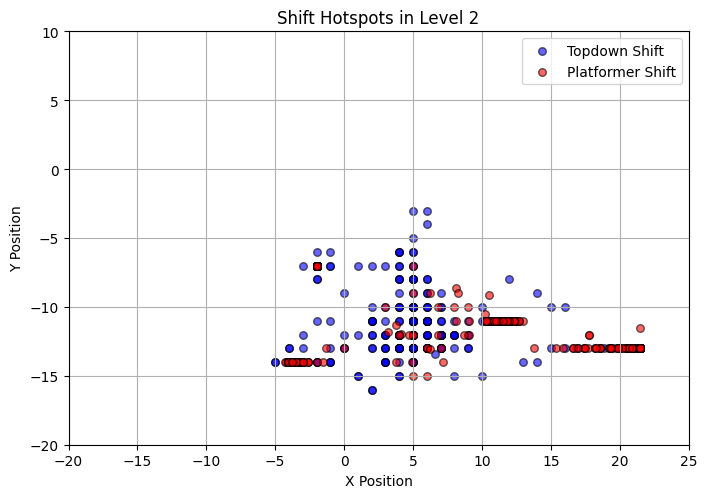

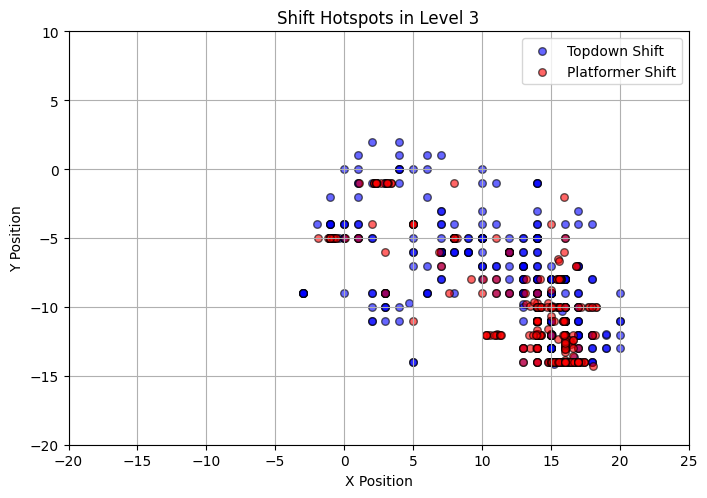

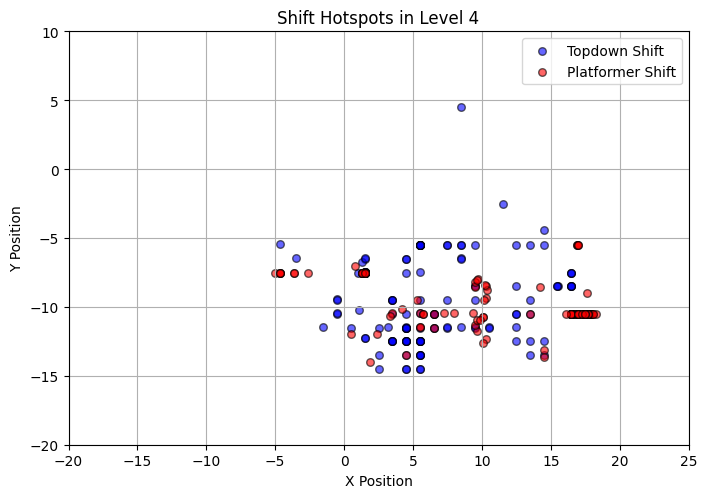

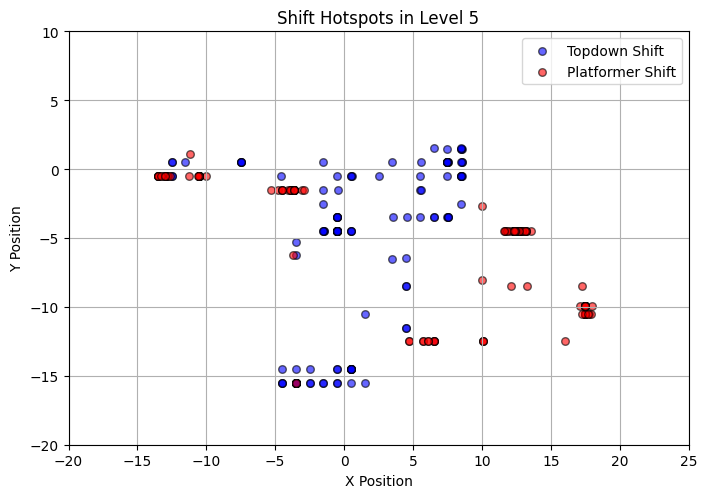

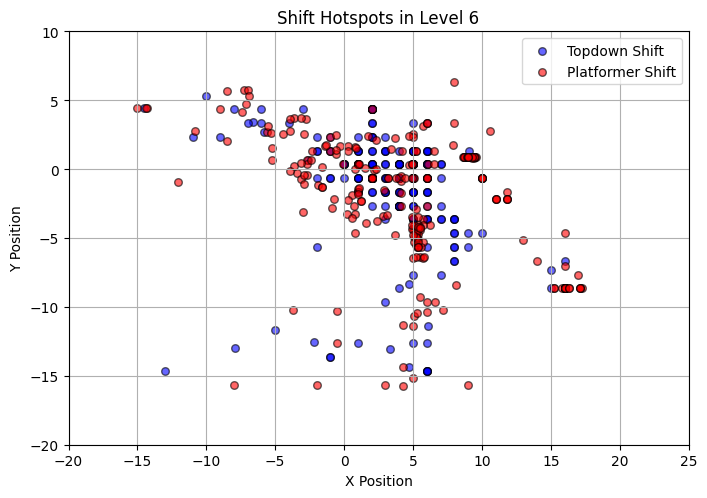

In [34]:
# # -------------------- Metric 3: Shift Distribution Point Map --------------------
x_min, x_max = -20, 25
y_min, y_max = -20, 10

# Starting from level2 because shift is disabled in level0 and level1
for level_idx in range(2, number_of_levels):
    topdown_positions = shift_positions_topdown_by_level[level_idx]
    platformer_positions = shift_positions_platformer_by_level[level_idx]

    plt.figure(figsize=(8, 6))

    topdown_positions = [(p['x'], p['y']) for p in topdown_positions if p is not None]
    platformer_positions = [(p['x'], p['y']) for p in platformer_positions if p is not None]

    # Plot 2D Shift
    if topdown_positions:
        topdown_x, topdown_y = zip(*topdown_positions)
        plt.scatter(topdown_x, topdown_y, c='blue', label='Topdown Shift',
                    alpha=0.6, edgecolors='k', s=30)

    # Plot 3D Shift
    if platformer_positions:
        platformer_x, platformer_y = zip(*platformer_positions)
        plt.scatter(platformer_x, platformer_y, c='red', label='Platformer Shift',
                    alpha=0.6, edgecolors='k', s=30)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.legend()
    # Saving for plot
    plt.savefig(f'shift_level{level_idx}.png', dpi=300, bbox_inches='tight', transparent=True)

    plt.title(f'Shift Hotspots in Level {level_idx}')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


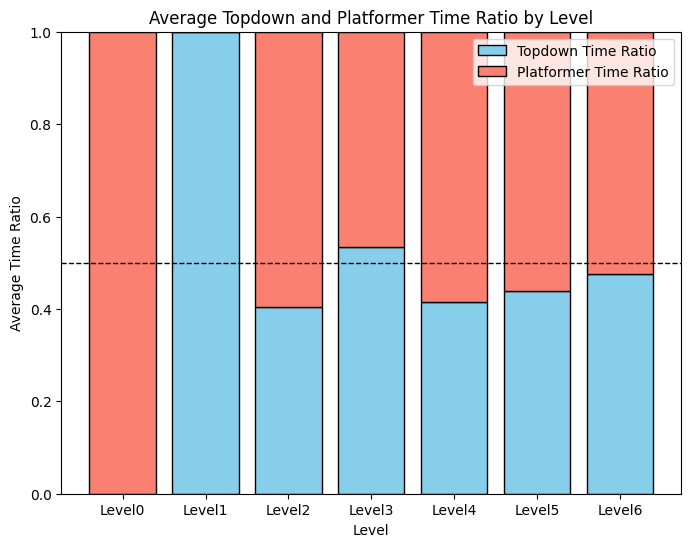

In [9]:
# -------------------- Metric 4: Average Topdown and Platformer Time Ratio by Level --------------------
average_platformer_time_by_level = [1 - x for x in average_topdown_ratio_by_level]

plt.figure(figsize=(8, 6))
# Plot topdown ratio as the base, then stack platformer ratio on top.
plt.bar(levels, average_topdown_ratio_by_level, edgecolor='black', label='Topdown Time Ratio', color='skyblue')
plt.bar(levels, average_platformer_time_by_level, edgecolor='black', bottom=average_topdown_ratio_by_level, 
        label='Platformer Time Ratio', color='salmon')
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
plt.xlabel('Level')
plt.ylabel('Average Time Ratio')
plt.title('Average Topdown and Platformer Time Ratio by Level')
plt.legend()
plt.show()